In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gammaln
from scipy.stats import truncnorm
import seaborn as sns

sns.set_palette('hls', desat=0.6)
sns.set_context(rc={'figure.figsize': (6,4)})
sns.set()

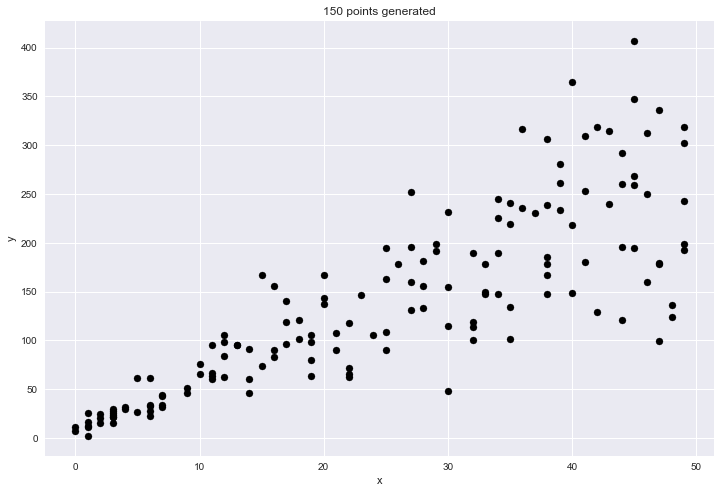

In [17]:
np.random.seed(123)
b0 = 10
b1 = 5

N = 150
x = np.random.randint(0, 50, N)

true_mu = b0 + b1 * x
true_r = 10
p = 1 - true_mu / (true_r + true_mu)

y = np.random.negative_binomial(n=true_r, p=p)

plt.scatter(x, y, color='black')
plt.xlabel('x')
plt.ylabel('y')
plt.title('150 points generated')
plt.show()

In [18]:
def calc_mu(beta, x):
    return beta[0] + beta[1]*x

def nb_acceptance_ratio(theta, theta_p, y, N):
    mu, r = theta
    mu_p, r_p = theta_p

    term1 = r_p * np.log(r_p/(r_p+mu_p))
    term2 = -r * np.log(r/(r+mu))
    term3 = y * np.log(mu_p/mu*(mu+r)/(mu_p+r_p))
    term4 = gammaln(r_p + y)
    term5 = -gammaln(r + y)
    term6 = N * (gammaln(r) - gammaln(r_p))

    return (term1+term2+term3+term4+term5).sum() + term6

In [19]:
def metropolis_hastings(n_iter, burn_in, thin=5):
    
    sigma_b0 = 0.5
    sigma_b1 = 0.7
    sigma_r = 0.5
    
    trace = np.zeros((n_iter, 3))
    trace[0,:] = np.array([5, 5, 1])
    acceptance_rate = np.zeros(n_iter)
    mu = calc_mu(trace[0,:2], x)
    
    for i in range(1, n_iter):
        theta = trace[i-1,:]
        theta_p = np.array([np.random.normal(theta[0], sigma_b0),
                            np.random.normal(theta[1], sigma_b1),
                            truncnorm.rvs(-theta[2]/sigma_r, np.Inf, loc=theta[2], scale=sigma_r)])
        mu_p = calc_mu(theta_p[:2], x)

        if np.any(mu_p <= 0):
            print("mu == 0 on iteration {}".format(i))

        alpha = nb_acceptance_ratio((mu, theta[2]), (mu_p, theta_p[2]), y, N)
        u = np.log(np.random.uniform())

        if u < alpha:
            trace[i,:] = theta_p
            mu = mu_p
            acceptance_rate[i-1] = 1
        else:
            trace[i,:] = theta
            
    print(acceptance_rate[burn_in:].mean())
    return trace[burn_in::thin,:]

In [34]:
n_iter = 500000
burn_in = 4000
trace = metropolis_hastings(n_iter, burn_in)

0.24699798387096775


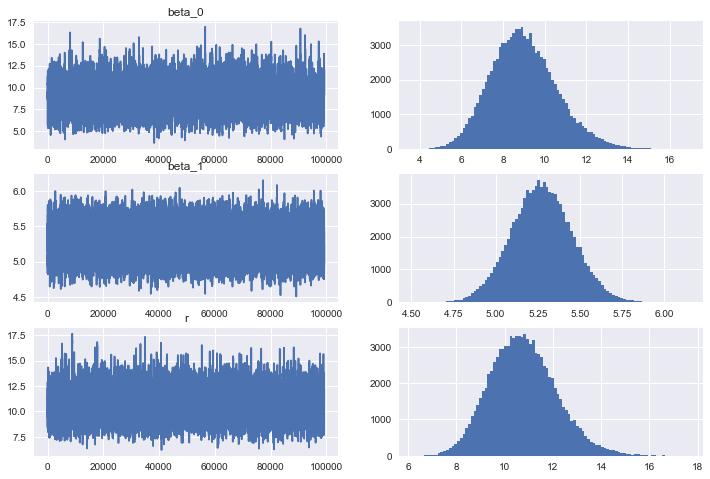

In [35]:
import pylab
pylab.rcParams['figure.figsize'] = (12, 8)

plt.subplot(3,2,1)
plt.plot(trace[:,0])
plt.title('beta_0')

plt.subplot(3,2,2)
plt.hist(trace[:,0], bins=100)

plt.subplot(3,2,3)
plt.plot(trace[:,1])
plt.title('beta_1')

plt.subplot(3,2,4)
plt.hist(trace[:,1], bins=100)

plt.subplot(3,2,5)
plt.plot(trace[:,2])
plt.title('r')

plt.subplot(3,2,6)
plt.hist(trace[:,2], bins=100)

plt.show()

In [36]:
trace[:,0].mean(), trace[:,1].mean(), trace[:,2].mean()

(8.993299778223284, 5.274497833082735, 10.77328833105406)